## **Neural Networks NLP analysis**

In [1]:
# pomocnicze
import re
import string
import numpy as np
import pandas as pd
import csv

# wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

# preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim
from gensim.utils import simple_preprocess

# model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# ewaluacja
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### Podłączenie dysku Google

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path = '/content/drive/MyDrive/tweets_labeled_bi.csv'   
tweets_txt = pd.read_csv(path, delimiter = ",", encoding='utf-8')
tweets_txt.head()

,Unnamed: 0,text,clean_text,cleaned_text,sentiment,sentiments_val
0,0,"kiedy #coronavirus dotrze do polski, napotka o...","['coronavirus', 'dotrze', 'polski', 'napotka',...",coronavirus dotrze polski napotka opór znakomi...,0,negative
1,1,kolejni polacy chcą wrócić z wuhan https://t.c...,"['kolejni', 'polacy', 'chcą', 'wrócić', 'wuhan']",kolejni polacy chcą wrócić wuhan,0,negative
2,2,a tymczasem w wuhan odcięto od reszty świata o...,"['tymczasem', 'wuhan', 'odcięto', 'reszty', 'ś...",tymczasem wuhan odcięto reszty świata obszar p...,1,positive
3,3,@patrykwachowiec @kancelariasejmu nie zdziwię ...,"['zdziwię', 'powiedzą', 'listy', 'pojechały', ...",zdziwię powiedzą listy pojechały chin wuhan od...,0,negative
4,4,".@msz_rp: 19 polaków chce wrócić z wuhan, w am...","['rp', 'polaków', 'wrócić', 'wuhan', 'ambasadz...",rp polaków wrócić wuhan ambasadzie rp pekinie ...,0,negative


## Prepare data for NN algorithm
Data is already cleaned and preprocessed 

In [6]:
temp = []
data_to_list = tweets_txt['cleaned_text'].values.tolist()
temp = data_to_list
list(temp[:5])

['coronavirus dotrze polski napotka opór znakomicie zorganizowanego publicznego systemu ochrony zdrowia napotka',
 'kolejni polacy chcą wrócić wuhan',
 'tymczasem wuhan odcięto reszty świata obszar porównywalny syrii mcd starbucks zawiesili działalność',
 'zdziwię powiedzą listy pojechały chin wuhan odważny pojedzie',
 'rp polaków wrócić wuhan ambasadzie rp pekinie powołano sztab kryzysowy spotkanie']

In [7]:
data= np.array(temp)
data[:5]

array(['coronavirus dotrze polski napotka opór znakomicie zorganizowanego publicznego systemu ochrony zdrowia napotka',
       'kolejni polacy chcą wrócić wuhan',
       'tymczasem wuhan odcięto reszty świata obszar porównywalny syrii mcd starbucks zawiesili działalność',
       'zdziwię powiedzą listy pojechały chin wuhan odważny pojedzie',
       'rp polaków wrócić wuhan ambasadzie rp pekinie powołano sztab kryzysowy spotkanie'],
      dtype='<U135')

## Zamiana danych na wartości numeryczne

In [8]:
labels = np.array(tweets_txt['sentiments_val'])
y = []
for i in range(len(labels)):
    if labels[i] == "negative":
        y.append(0)
    if labels[i] == "positive":
        y.append(1)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 2, dtype="float32")
del y

In [9]:
len(labels)

485087

## Zamiana danych na tensory

In [10]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  969  341   12]
 [   0    0    0 ...  186 1543   38]
 [   0    0    0 ... 3628  207 1825]
 ...
 [   0    0    0 ...    0    0  851]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...  851 3785  851]]


In [11]:
print(labels)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [12]:
# Podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

363815 121272 363815 121272


## 1. Bidirectional LSTM

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 40, input_length=max_len))
model1.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model1.add(layers.Dense(2,activation='softmax'))
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_model.hdf5", 
                              monitor='val_accuracy', 
                              verbose=1,
                              save_best_only=True, 
                              mode='auto', 
                              period=1,
                              save_weights_only=False)
history = model1.fit(X_train, 
                     y_train, 
                     epochs=30, 
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint])

Epoch 1/30
11370/11370 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8523
Epoch 00001: val_accuracy improved from -inf to 0.87334, saving model to /content/drive/MyDrive/best_model.hdf5
11370/11370 [==============================] - 917s 80ms/step - loss: 0.3227 - accuracy: 0.8523 - val_loss: 0.2825 - val_accuracy: 0.8733
Epoch 2/30
11370/11370 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.8729
Epoch 00002: val_accuracy improved from 0.87334 to 0.87536, saving model to /content/drive/MyDrive/best_model.hdf5
11370/11370 [==============================] - 905s 80ms/step - loss: 0.2832 - accuracy: 0.8729 - val_loss: 0.2781 - val_accuracy: 0.8754
Epoch 3/30
11370/11370 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8736
Epoch 00003: val_accuracy did not improve from 0.87536
11370/11370 [==============================] - 901s 79ms/step - loss: 0.2816 - accuracy: 0.8736 - val_loss: 0.2789 - val_accuracy: 0.8733
Epoc

### Ewaluacja modelu

In [44]:
model1 = keras.models.load_model("/content/drive/MyDrive/best_model.hdf5")

In [45]:
test_loss, test_acc = model1.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

3790/3790 - 72s - loss: 0.2784 - accuracy: 0.8767 - 72s/epoch - 19ms/step
Model accuracy:  0.8767399191856384


In [46]:
predictions1 = model1.predict(X_test)

### Confusion matrix

In [47]:
# from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions1, decimals=0).argmax(axis=1))

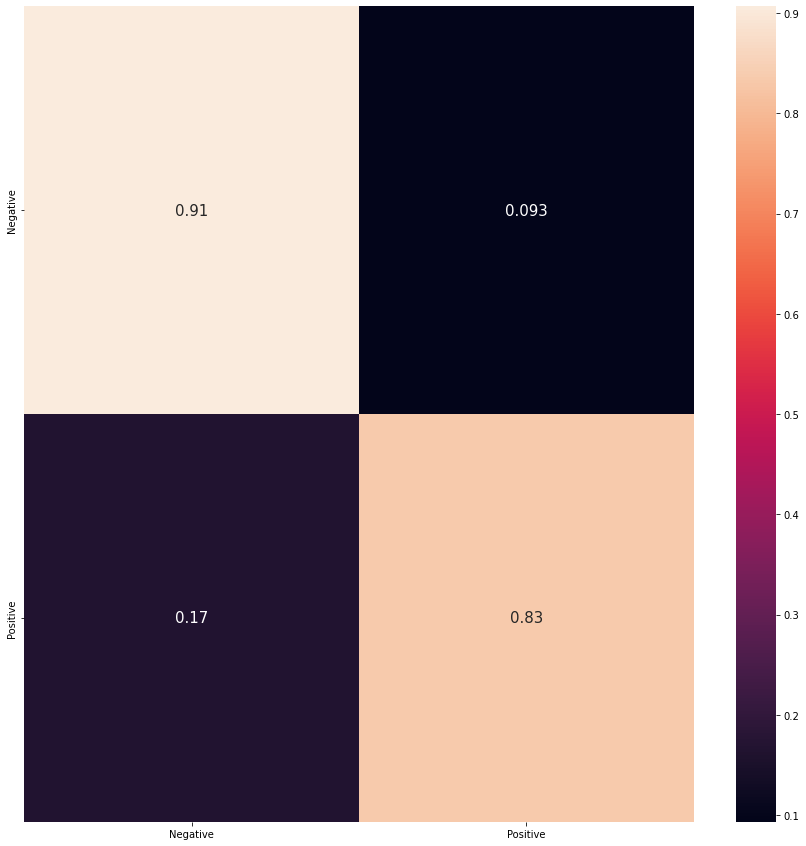

In [48]:
# import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Negative','Positive'],columns = ['Negative','Positive'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [49]:
sentiment = ['Negative','Positive']

In [50]:
sequence = tokenizer.texts_to_sequences(['covid to najgorsze co mnie w życiu spotkało'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model1.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [51]:
sequence = tokenizer.texts_to_sequences(['Rząd całkowicie sobie nie radzi z pandemią'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model1.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [52]:
sequence = tokenizer.texts_to_sequences(['wszystko wróci do normalności niedługo'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model1.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

##2. Convolutional model


In [26]:
from keras import regularizers
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Conv1D(20, 6, activation='relu' ,kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model2.add(layers.MaxPooling1D(5))
model2.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(2,activation='relu'))
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

checkpoint2 = ModelCheckpoint("/content/drive/MyDrive/best_model2.hdf5",
                              monitor='val_accuracy', 
                              verbose=1,
                              save_best_only=True,
                              mode='auto', 
                              period=1,
                              save_weights_only=False)
history = model2.fit(X_train, 
                     y_train, 
                     epochs=70,
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint2])

Epoch 1/70
11369/11370 [============================>.] - ETA: 0s - loss: 0.4457 - accuracy: 0.8416
Epoch 00001: val_accuracy improved from -inf to 0.86742, saving model to /content/drive/MyDrive/best_model2.hdf5
11370/11370 [==============================] - 105s 9ms/step - loss: 0.4457 - accuracy: 0.8416 - val_loss: 0.3567 - val_accuracy: 0.8674
Epoch 2/70
11368/11370 [============================>.] - ETA: 0s - loss: 0.4176 - accuracy: 0.8639
Epoch 00002: val_accuracy did not improve from 0.86742
11370/11370 [==============================] - 103s 9ms/step - loss: 0.4176 - accuracy: 0.8639 - val_loss: 0.5120 - val_accuracy: 0.8609
Epoch 3/70
11370/11370 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.8670
Epoch 00003: val_accuracy did not improve from 0.86742
11370/11370 [==============================] - 113s 10ms/step - loss: 0.4198 - accuracy: 0.8670 - val_loss: 0.4939 - val_accuracy: 0.8638
Epoch 4/70
11369/11370 [============================>.] - ETA: 0s

### Ewaluacja modelu

In [30]:
model2 = keras.models.load_model("/content/drive/MyDrive/best_model2.hdf5")

In [31]:
test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

3790/3790 - 13s - loss: 0.4063 - accuracy: 0.8737 - 13s/epoch - 3ms/step
Model accuracy:  0.8736971616744995


In [32]:
predictions2 = model2.predict(X_test)

### Confusion matrix

In [33]:
# from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions2, decimals=0).argmax(axis=1))

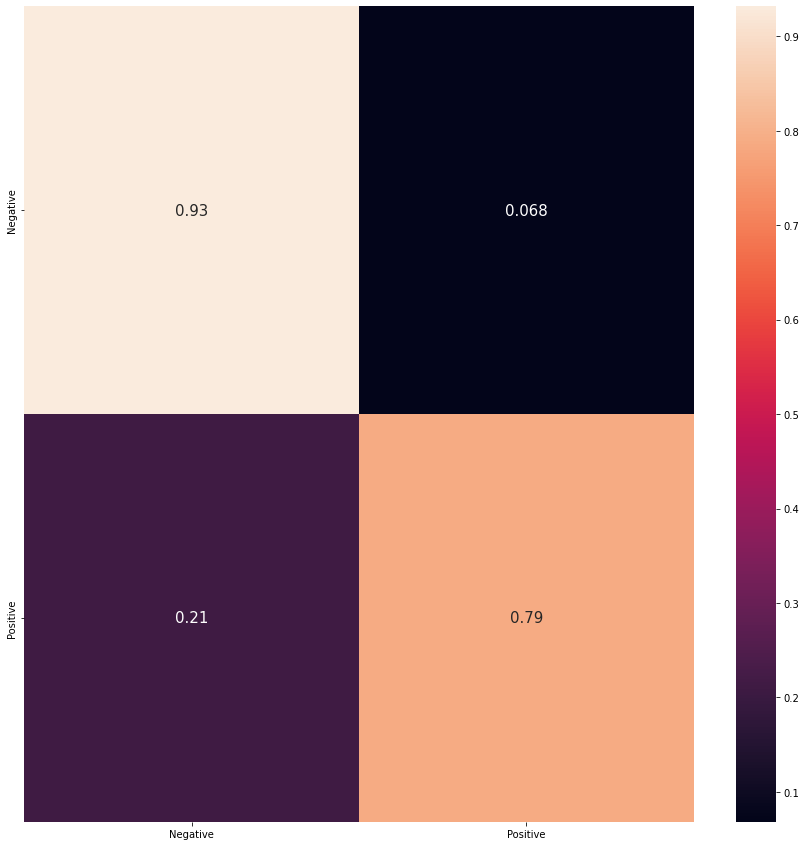

In [34]:
# import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Negative','Positive'],columns = ['Negative','Positive'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [35]:
sentiment = ['Negative','Positive']

In [36]:
sequence = tokenizer.texts_to_sequences(['Szczepienia są niezbędne aby zakończyć pandemię'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [37]:
sequence = tokenizer.texts_to_sequences(['Mój współpracownik zaraził mnie covidem'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [39]:
sequence = tokenizer.texts_to_sequences(['Cieszę się, że coraz mniej obawiamy się koronawirusa i epidemii. COVID-19 jest w odwrocie, już nie musimy się go bać. Trzeba pójść na wybory.'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'